# Energy budget model - 2 layer (Held et al. 2010)

A simple model with two layers: surface and deep ocean.

$$
\begin{align}
C\frac{dT_s}{dt} &=  F + \lambda T_s - \epsilon\gamma (T_s-T_d)  \\
C_d\frac{dT_d}{dt} &=  \gamma (T_s-T_d)
\end{align}
$$
In addition, we have the TOA radiation imbalance to further constrain the system.

$$
\begin{align}
N &= C\frac{dT_s}{dt} + C_d\frac{dT_d}{dt}
\end{align}
$$

The above equations are equvalent to :

$$
N = F + \lambda_s T_s - (\epsilon-1) \gamma (T_s-T_d)  \
$$


Free Parameters: $$\underline{m} = [C,C_d,\lambda,\epsilon,\gamma]$$


## Equilibrium Climate Sensitivity (ECS)
    
At equilirium state, 
$$\frac{dT_s}{dt} = \frac{dT_d}{dt} = 0 .$$
Then, we have
$$
\begin{align}
0 & = F + \lambda \cdot ECS - \epsilon\gamma (T_s-T_d)\\
0 & = T_s-T_d \\
\Rightarrow ECS &=  - \frac{F}{\lambda}
\end{align}
$$


## Effective Climate Sensitivity (EffCS)
EffCS is an approximation of ECS using the first 150 years of abrupt-4xCO2 experiment.

# Change in climate feedback

For t~0, we have $$ T_s\approx T_d\approx 0 $$

So,
$$
\begin{align}
C\frac{dT_s}{dt} &=  F + \lambda T_s - \epsilon\gamma T_s\\
N &= F + \lambda T_s - (\epsilon-1)\gamma T_s
\end{align}
$$
The climate feeback at beginning is

$$
\begin{align} 
\lambda_1 &= \frac{dN}{dT_s} |_{t\approx 0}\\
&= \lambda -(\epsilon-1)\gamma
\end{align}
$$

For t~$\infty$, we have $$ C\frac{dT_s}{dt} <<C_d\frac{dT_d}{dt}  $$

So,
$$
\begin{align}
0 &=  F + \lambda T_s - \epsilon\gamma T_s + \epsilon\gamma T_d \\ 
N &= \gamma (T_s-T_d)
\end{align}
$$
The climate feeback close to end is

$$
\begin{align} 
\lambda_2 &= \frac{dN}{dT_s} |_{t\approx \infty}\\
&= \gamma \frac{d}{dT_s}(T_s+\frac{F + \lambda T_s - \epsilon\gamma T_s}{\epsilon\gamma})\\
&= \frac{d}{dT_s}\frac{F + \lambda T_s }{\epsilon}\\
&= \frac{\lambda }{\epsilon}
\end{align}
$$

The change in climate feedback:


$$
\begin{align} 
\Delta\lambda &= \lambda_2 - \lambda_1\\
&= \frac{\lambda }{\epsilon} - \lambda +(\epsilon-1)\gamma\\
&= \lambda\frac{1- \epsilon }{\epsilon} +(\epsilon-1)\gamma\\
&= (\epsilon-1)(-\frac{\lambda }{\epsilon} + \gamma)
\end{align}
$$

So, if $\epsilon> 1$, $\Delta\lambda >0.$

# Code

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression as LiRe
import csv
from scipy.interpolate import interp1d
from scipy import stats

## Global Parameter

In [2]:
ar1_para = [0.5,0.000]
# 4xCO2
F_4xCO2 = 8.

### Historical forcing

### Functions

In [3]:

def EBM2L_forcing(t,T2,F_func,C1,C2,lambda1,epl1,gma1,F_para=None):
#     print(t, end = ' ')
    F = F_func(t,F_para)
    dydt = np.empty(2)
    dydt[0] = (F + lambda1*T2[0] - epl1*gma1*(T2[0]-T2[1]))/C1
    dydt[1] = (gma1*(T2[0]-T2[1]) )/C2
    return dydt

# ar1 noise
def ar1_noise(length,ar1_para,rng):
    rho,var = ar1_para
    ar1_noise = np.empty(length)
    wn_std = np.sqrt(var*(1-rho**2))
    ar1_noise[0] = rng.normal(0,scale=wn_std)
    for i in range(length-1):
        ar1_noise[i+1] = ar1_noise[i]*rho + rng.normal(0,scale=wn_std)
    return ar1_noise


def F_linear_func(t,k):
    F = 2*1.01**t
    return F

def F_func_array(t,F_func,F_para):
    F_array = np.empty_like(t)
    for i in range(t.shape[0]):
        F_array[i] = F_func(t[i],F_para)
    return F_array

def run_EBM2L_4xCO2(dyn_para, ar1_para, F_4xCO2, rng):
    '''
    run 4xCO2 with specified parameters
    '''
    # constant forcing
    def F_abrupt_4xCO2_func(t,F_4xCO2):
        return F_4xCO2
    t_lim = [0,150]

    T2_ode,N_diag = run_EBM2L_F_fun(t_lim,dyn_para,ar1_para,F_abrupt_4xCO2_func,F_4xCO2,rng )
    
    # compute the ECS in abrupt-4xCO2 experiment 
    single_fit_tmp = LiRe().fit(T2_ode[0,:].reshape(-1, 1), N_diag)
    ERF_2xCO2 = single_fit_tmp.intercept_ / 2
    Lambda150 = single_fit_tmp.coef_
    EffCS = - ERF_2xCO2 / Lambda150
    single_fit_tmp = LiRe().fit(T2_ode[0,20:].reshape(-1, 1), N_diag[20:])
    Lambda20150 = single_fit_tmp.coef_
    EffCS20150 = - single_fit_tmp.intercept_ / 2 / Lambda20150
    return EffCS,Lambda150,ERF_2xCO2,Lambda20150,EffCS20150,T2_ode,N_diag

def run_EBM2L_F_fun(t_lim, dyn_para, ar1_para, F_func, F_para,rng):
    '''
    run with any parameters and any forcing
    '''
    C1 ,C2, lambda1, epl1, gma1 = dyn_para
    # compute the ECS in abrupt-4xCO2 experiment 
    t_eval = np.arange(t_lim[0],t_lim[1],1)
    # run ode solver
    sol_4xCO2 = solve_ivp(EBM2L_forcing, [t_lim[0],t_lim[1]], [0,0], t_eval=t_eval, 
                          method='RK45',  rtol=1e-3, atol=1e-3, 
                          args=(F_func, C1, C2, lambda1, epl1, gma1, F_para))
    T2_ode = sol_4xCO2.y
    # add ar1 noise
    T_ar1 = ar1_noise(t_eval.shape[0],ar1_para,rng)
    T2_ode[0,:] = T2_ode[0,:] + T_ar1 
    F_array = F_func_array(t_eval,F_func,F_para)
    # diagnose the TOA radiatoin: N
    N_diag = F_array + lambda1*T2_ode[0,:]- (epl1-1)*gma1*(T2_ode[0,:]-T2_ode[1,:])
    return T2_ode,N_diag
 

# Single exmple

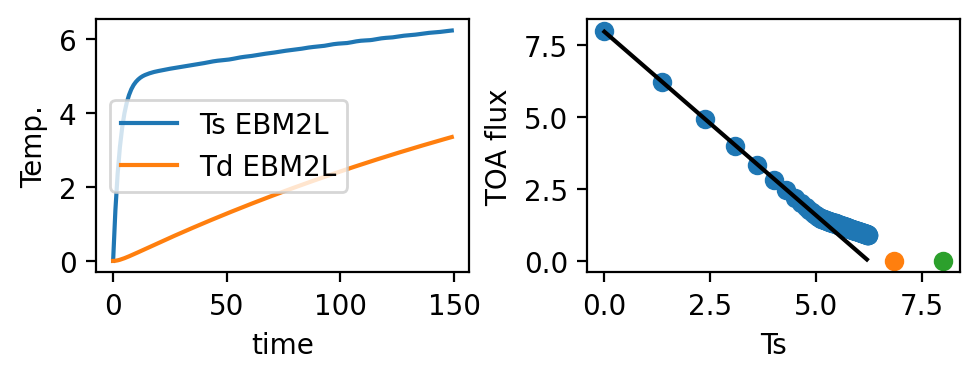

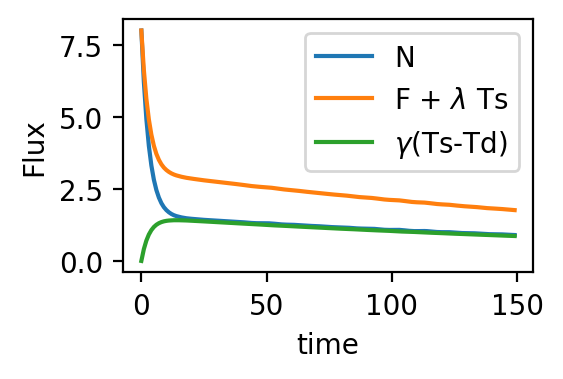

In [4]:
dyn_parameters = [5,50,-1,2,0.3]
ar1_para_0 = [0.5,0.00]

rng = np.random.default_rng(1234)
EffCS,Lambda150,ERF_2xCO2,Lambda20150,EffCS20150,T2_ode,N_diag \
= run_EBM2L_4xCO2(dyn_parameters,ar1_para_0,F_4xCO2,rng)
from scipy import stats
x_tmp = T2_ode[0,:]
regli020 = stats.linregress(x_tmp[:20], N_diag[:20])
x_tmp = np.arange(0,-regli020.intercept/regli020.slope,0.1)
y_tmp = regli020.slope* x_tmp + regli020.intercept


fig = plt.figure(figsize=(5,2),dpi=200)
ax1 = plt.subplot(1,2,1)
t_fit = np.arange(0,N_diag.shape[0],1)
p = ax1.plot(t_fit,T2_ode[0,:], label='Ts EBM2L')
p = ax1.plot(t_fit,T2_ode[1,:], label='Td EBM2L')

ax1.legend()
ax1.set_xlabel('time')
ax1.set_ylabel('Temp.')

ax1 = plt.subplot(1,2,2)
p = ax1.plot(x_tmp,y_tmp,color='black')
p = ax1.scatter(T2_ode[0,:],N_diag)
p = ax1.scatter(EffCS*2,0)
p = ax1.scatter(-F_4xCO2/dyn_parameters[2],0)
ax1.set_xlabel('Ts')
ax1.set_ylabel('TOA flux')
fig.tight_layout()
fig.show()

fig = plt.figure(figsize=(5,2),dpi=200)
ax1 = plt.subplot(1,2,1)
t_fit = np.arange(0,N_diag.shape[0],1)
p = ax1.plot(t_fit,N_diag, label='N')
p = ax1.plot(t_fit,dyn_parameters[2]*T2_ode[0,:]+8, label=r'F + $\lambda$ Ts')
tmp = dyn_parameters[4]*(T2_ode[0,:]-T2_ode[1,:])
p = ax1.plot(t_fit,tmp, label=r'$\gamma$(Ts-Td)')

ax1.legend()
ax1.set_xlabel('time')
ax1.set_ylabel('Flux')

# ax1 = plt.subplot(1,2,2)
# # p = ax1.scatter(T2_ode[0,:],N_diag)
# # p = ax1.scatter(EffCS*2,0)
# # ax1.set_xlabel('Temp.')
# # ax1.set_ylabel('TOA flux')
fig.tight_layout()
fig.show()